### clinvar missense prediction w/ feature intersection
* only use consistent positions
* only missense clinvar
* use positions w/ mpc **OR** pathogenic fraction
* quick roc evaluation by gene

In [2]:
import pandas, numpy
import pydot, pydotplus, graphviz
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn import linear_model, metrics, tree, svm
from sklearn.neural_network import MLPClassifier
from sklearn.externals.six import StringIO
from sklearn.preprocessing import PolynomialFeatures
from IPython.display import HTML
%matplotlib inline

In [3]:
def calc_path_frac(rows):
    pfam = list(rows['pfam'].values)[0]
    pathogenic = len(rows[ (rows.clin_class=='PATHOGENIC') | (rows.clin_class=='LIKLEY_PATHOGENIC')])
    benign = len(rows[ (rows.clin_class=='LIKELY_BENIGN') | (rows.clin_class=='BENIGN')])
    frac = -1
    if pathogenic+benign:
        frac = pathogenic/(pathogenic+benign)
    return pandas.Series([frac, len(rows)], index=['path_frac', 'size'])

dat_file = '../data/interim/EPIv6.eff.dbnsfp.anno.hHack.dat.xls'
df_pre = pandas.read_csv(dat_file, sep='\t').fillna(0)
df = (df_pre['pfam'].str.split(',', expand=True)
     .stack()
     .reset_index(level=0)
     .set_index('level_0')
     .rename(columns={0:'pfam'})
     .join(df_pre.drop('pfam',1), how='left')
     )
dd = df.groupby('pfam').apply(calc_path_frac)
ff = dd.reset_index()

# mk domain features
def match(row, domain_info):
    ls = []
    for pfam in row['pfam'].split(','):
        if pfam in domain_info:
            if domain_info[pfam][2] == 0:
                ls.append(domain_info[pfam])
    if len(ls) == 0:
        for pfam in row['pfam'].split(','):
            if pfam in domain_info:
                return domain_info[pfam]
        
    if len(ls):
        return ls[0]
    else:
        return (0, 0, 1)
    
ff.loc[:, 'path_na'] = ff.apply(lambda row: 1 if row['path_frac']==-1 else 0, axis=1)
domain_info = {pfam:[path_frac, size, path_na]
               for pfam, path_frac, size, path_na
               in ff.values}

df_pre.loc[:, 'path_frac_t'] = df_pre.apply(lambda row: match(row, domain_info)[0], axis=1)
df_pre.loc[:, 'size_t'] = df_pre.apply(lambda row: match(row, domain_info)[1], axis=1)
df_pre.loc[:, 'path_na_t'] = df_pre.apply(lambda row: match(row, domain_info)[2], axis=1)
df_pre.loc[:, 'in_none_pfam'] = df_pre.apply(lambda row: 1 if 'none' in df_pre['pfam'] else 0, axis=1)

In [4]:
# this is for training
# use not just missense
# I do not need to require an mpc score here anymore
df_x_pre = df_pre[ (df_pre.clin_class != 'VUS') & 
                   (df_pre.mpc>0)]
df_s = df_x_pre.groupby('pfam').size().reset_index()
multi_pfam = set( df_s[df_s[0]>1]['pfam'].values )
df_x_pre.loc[:, 'multi_pfam'] = df_x_pre.apply(lambda row: row['pfam'] in multi_pfam, axis=1)
df_x = df_x_pre[df_x_pre.multi_pfam]
df_x.loc[:, 'y'] = df_x.apply(lambda row: 1 if row['clin_class'] in ('PATHOGENIC', 'LIKLEY_PATHOGENIC')
                            else 0, axis=1)
df_x.head()

/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,chrom,pos,ref,alt,clin_class,pfam,af_1kg_all,eff,pos_fam,neg_fam,...,kaviar_af,c.,Protein_Change,Hugo_Symbol,path_frac_t,size_t,path_na_t,in_none_pfam,multi_pfam,y
18,1,40557754,A,C,PATHOGENIC,Palm_thioest:10,0.0,missense_variant,1,8544,...,0.000006,NM_000310.3:c.325T>G,Y109D,PPT1,0.5,3.0,0,0,True,1
19,1,40557769,T,C,LIKELY_BENIGN,Palm_thioest:10,0.0,missense_variant,2,8543,...,0.000019,NM_000310.3:c.310A>G,K104E,PPT1,0.5,3.0,0,0,True,0
34,1,43393355,C,T,PATHOGENIC,"MFS_1:44,Sugar_tr:29",0.0,missense_variant,1,8419,...,0.000000,NM_006516.2:c.1199G>A,R400H,SLC2A1,1.0,9.0,0,0,True,1
35,1,43393356,G,A,PATHOGENIC,"MFS_1:44,Sugar_tr:29",0.0,missense_variant,2,8418,...,0.000006,NM_006516.2:c.1198C>T,R400C,SLC2A1,1.0,9.0,0,0,True,1
36,1,43393397,A,C,LIKLEY_PATHOGENIC,"MFS_1:44,Sugar_tr:29",0.0,missense_variant,1,8419,...,0.000006,NM_006516.2:c.1157T>G,I386S,SLC2A1,1.0,9.0,0,0,True,1


In [9]:
clin_file = '../data/interim/clinvar/clinvar.dat'
clinvar_df_pre = pandas.read_csv(clin_file, sep='\t').fillna(0)
def calc_final_sig(row):
    sig_set = set(str(row['clinSig'].split('|')))
    has_benign = '2' in sig_set or '3' in sig_set
    has_path = '4' in sig_set or '5' in sig_set
    if has_path and not has_benign:
        return 1
    if not has_path and has_benign:
        return 0
    return -1

clinvar_df_pre.loc[:, "y"] = clinvar_df_pre.apply(calc_final_sig, axis=1)
clinvar_df = clinvar_df_pre[(clinvar_df_pre.eff=='missense_variant') 
                            & (clinvar_df_pre.y!=-1) 
                            & (clinvar_df_pre.mpc>0)
                            & (clinvar_df_pre.pfam != 'fuck')].drop_duplicates()
clinvar_df.loc[:, 'path_frac_t'] = clinvar_df.apply(lambda row: match(row, domain_info)[0], axis=1)
clinvar_df.loc[:, 'size_t'] = clinvar_df.apply(lambda row: match(row, domain_info)[1], axis=1)
clinvar_df.loc[:, 'path_na_t'] = clinvar_df.apply(lambda row: match(row, domain_info)[2], axis=1)
clinvar_df.loc[:, 'in_none_pfam'] = clinvar_df.apply(lambda row: 1 if 'none' in row['pfam'] else 0, axis=1)
# need a smarter match to domain here
#m = pandas.merge(clinvar_df, ff, on='pfam', how='left')
#m.head()

In [10]:
print(len(clinvar_df))
print(len(clinvar_df[clinvar_df.y==1]))
print(len(clinvar_df[clinvar_df.y==0]))

1340
966
374


In [20]:
def roc_by_gene(genes, df):
    crit = df.apply(lambda row: row['gene'] in genes, axis=1)
    clinvar_df = df[crit]
    
    gene = ','.join(genes)
    
    print(len(clinvar_df), gene)
    print(len(clinvar_df[clinvar_df.y==1]), gene)
    print(len(clinvar_df[clinvar_df.y==0]), gene)
    
    # train new tree and apply to clinvar
    tree_clf = linear_model.LogisticRegression(penalty='l1', fit_intercept=True)
    poly = PolynomialFeatures(degree=4, interaction_only=False, include_bias=False)

    all_preds = []
    all_truth = []
    cols = ['mpc', 'size_t', 'path_na_t', 'path_frac_t', 'in_none_pfam']
    X, y = poly.fit_transform(df_x[cols]), df_x['y']
    tree_clf.fit(X, y)

    X_clin, y_clin = poly.fit_transform(clinvar_df[cols]), clinvar_df['y']
    preds = [ x[1] for x in tree_clf.predict_proba(X_clin) ]
    clinvar_df['tree_pred'] = preds
#    clinvar_df.loc[:, 'tree_correct'] = clinvar_df.apply(eval_pred, axis=1)
    fpr_tree, tpr_tree, _ = metrics.roc_curve(y_clin, preds, pos_label=1)
    tree_auc = metrics.auc(fpr_tree, tpr_tree)
    
    # train new tree and apply to clinvar: just pathogenic frac
    tree_clf = linear_model.LogisticRegression(fit_intercept=True)
    poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

    all_preds = []
    all_truth = []
    cols = ['size_t', 'path_na_t', 'path_frac_t', 'in_none_pfam']
    X, y = df_x[cols], df_x['y']
    tree_clf.fit(X, y)

    X_clin, y_clin = clinvar_df[cols], clinvar_df['y']
    preds = [ x[1] for x in tree_clf.predict_proba(X_clin) ]
    fpr_tree_nm, tpr_tree_nm, _ = metrics.roc_curve(y_clin, preds, pos_label=1)
    tree_auc_nm = metrics.auc(fpr_tree_nm, tpr_tree_nm)
    
    scores = clinvar_df['mpc'].values
    truth = clinvar_df['y'].values
    fpr_mpc, tpr_mpc, _ = metrics.roc_curve(truth, scores, pos_label=1)
    mpc_auc = metrics.auc(fpr_mpc, tpr_mpc)
    
    print('mpc auc', mpc_auc, gene)
    print('tree auc', tree_auc, gene)
    print('tree-no-mpc auc', tree_auc_nm, gene)
    plt.plot(fpr_tree, tpr_tree, label='tree', color='green')
    plt.plot(fpr_tree_nm, tpr_tree_nm, label='tree-no-mpc', color='orange')
    plt.plot(fpr_mpc, tpr_mpc, label='mpc', color='black')
    plt.legend(loc=4)
    plt.title('%s ClinVar missense variant ROC curve' % (gene,))
    plt.savefig('../docs/plots/missense_clinvar_roc_feature_union.%s.png' % (gene,))

391 SCN1A,SCN2A,KCNQ2,KCNQ3
365 SCN1A,SCN2A,KCNQ2,KCNQ3
26 SCN1A,SCN2A,KCNQ2,KCNQ3


/opt/conda/lib/python3.4/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


mpc auc 0.909799789252 SCN1A,SCN2A,KCNQ2,KCNQ3
tree auc 0.946469968388 SCN1A,SCN2A,KCNQ2,KCNQ3
tree-no-mpc auc 0.917492096944 SCN1A,SCN2A,KCNQ2,KCNQ3


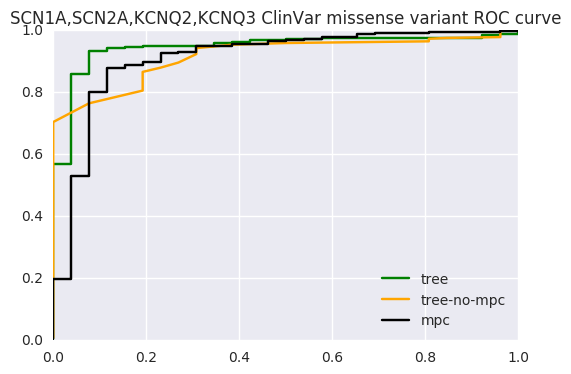

In [21]:
roc_by_gene( ('SCN1A','SCN2A','KCNQ2', 'KCNQ3'), clinvar_df)

231 SCN1A
226 SCN1A
5 SCN1A
mpc auc 0.845132743363 SCN1A
tree auc 0.948672566372 SCN1A
tree-no-mpc auc 0.802654867257 SCN1A


/opt/conda/lib/python3.4/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


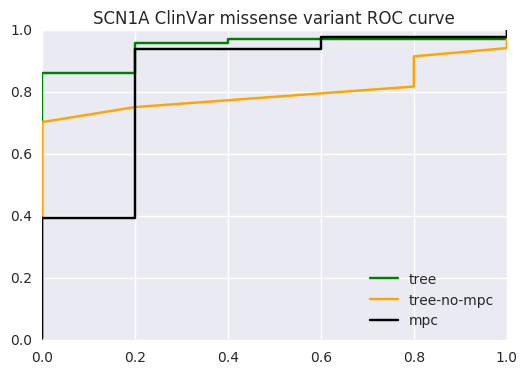

In [22]:
roc_by_gene(('SCN1A',), clinvar_df)

63 SCN2A
59 SCN2A
4 SCN2A
mpc auc 0.800847457627 SCN2A
tree auc 0.936440677966 SCN2A
tree-no-mpc auc 0.900423728814 SCN2A


/opt/conda/lib/python3.4/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


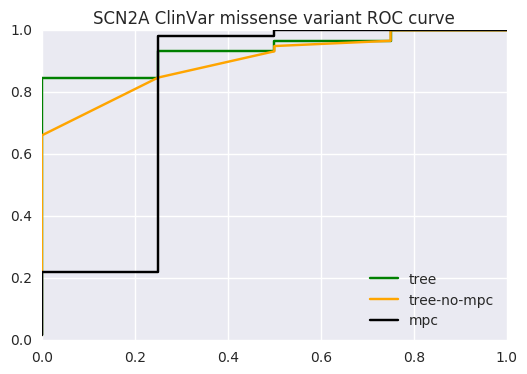

In [23]:
roc_by_gene(('SCN2A',), clinvar_df)

80 KCNQ2
69 KCNQ2
11 KCNQ2
mpc auc 0.96442687747 KCNQ2
tree auc 0.978919631094 KCNQ2
tree-no-mpc auc 0.949934123847 KCNQ2


/opt/conda/lib/python3.4/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


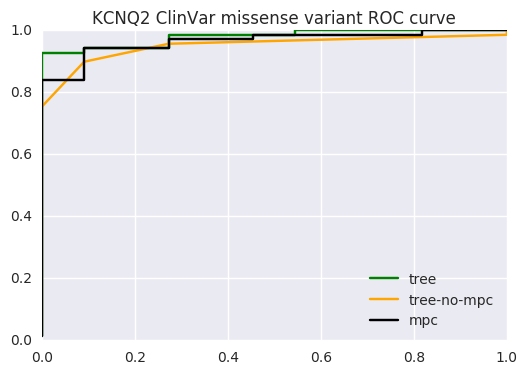

In [24]:
roc_by_gene( ('KCNQ2',), clinvar_df)

17 KCNQ3
11 KCNQ3
6 KCNQ3
mpc auc 0.787878787879 KCNQ3
tree auc 0.712121212121 KCNQ3
tree-no-mpc auc 0.795454545455 KCNQ3


/opt/conda/lib/python3.4/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


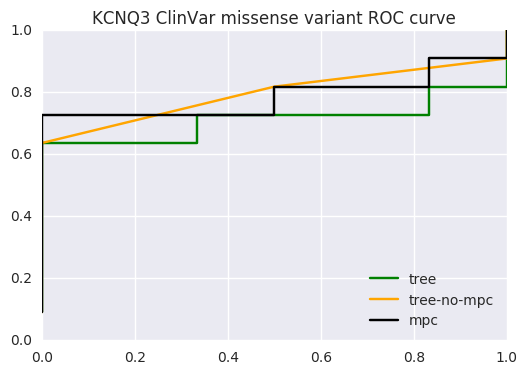

In [25]:
roc_by_gene( ('KCNQ3',), clinvar_df)

In [35]:
def eval_pred(row):
    if (row['tree_pred']>.9 and row['y']==1) or (row['tree_pred']<.1 and row['y']==0):
        return 'right'
    if (row['tree_pred']>.9 and row['y']==0) or (row['tree_pred']<.1 and row['y']==1):
        return 'wrong'
    return 'vus'

# train new tree and apply to clinvar
tree_clf = linear_model.LogisticRegression(penalty='l1', fit_intercept=True)
poly = PolynomialFeatures(degree=4, interaction_only=False, include_bias=False)

all_preds = []
all_truth = []
cols = ['mpc', 'size_t', 'path_na_t', 'path_frac_t', 'in_none_pfam']
X, y = poly.fit_transform(df_x[cols]), df_x['y']
tree_clf.fit(X, y)

X_clin, y_clin = poly.fit_transform(clinvar_df[cols]), clinvar_df['y']
preds = [ x[1] for x in tree_clf.predict_proba(X_clin) ]
clinvar_df['tree_pred'] = preds
clinvar_df.loc[:, 'tree_correct'] = clinvar_df.apply(eval_pred, axis=1)
fpr_tree, tpr_tree, _ = metrics.roc_curve(y_clin, preds, pos_label=1)
tree_auc = metrics.auc(fpr_tree, tpr_tree)

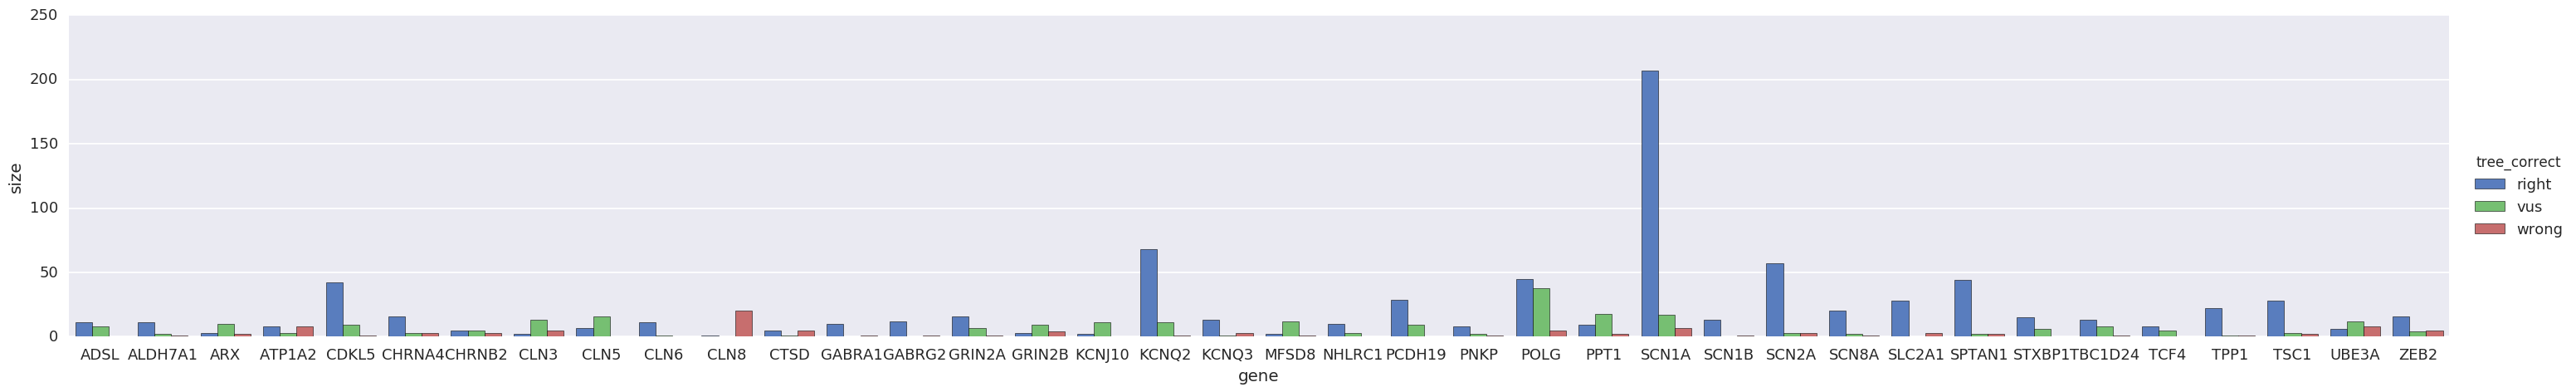

In [87]:
#plt.rcParams['figure.figsize'] = 20, 6
#plt.figure(figsize=(40,6))
#f, ax = plt.subplots(figsize=(40,6))
#sns.set_context("talk")
g_df = (clinvar_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'tree_correct']]
        .groupby(['gene','tree_correct'])
        .size().reset_index().rename(columns={0:'size'}))
dd = g_df.groupby('gene').sum().reset_index()
use_genes = set(dd[dd['size']>10]['gene'].values)
g_df.loc[:, 'keep'] = g_df.apply(lambda row: row['gene'] in use_genes, axis=1)
ss = sns.factorplot(x='gene', hue='tree_correct', y='size', data=g_df[g_df['keep']],
               kind='bar', palette='muted', size=5, aspect=6)
ss.savefig("../docs/plots/clinvar_gene_eval.png")
#plt.figure(figsize=(50, 3))

In [23]:
# train new tree and apply to clinvar: just pathogenic frac
tree_clf = linear_model.LogisticRegression(fit_intercept=True)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

all_preds = []
all_truth = []
cols = ['size_t', 'path_na_t', 'path_frac_t', 'in_none_pfam']
X, y = df_x[cols], df_x['y']
tree_clf.fit(X, y)

X_clin, y_clin = clinvar_df[cols], clinvar_df['y']
preds = [ x[1] for x in tree_clf.predict_proba(X_clin) ]
fpr_tree_nm, tpr_tree_nm, _ = metrics.roc_curve(y_clin, preds, pos_label=1)
tree_auc_nm = metrics.auc(fpr_tree_nm, tpr_tree_nm)

In [91]:
clinvar_df[clinvar_df['gene']=='CLN8'].head()

,chrom,pos,ref,alt,pfam,eff,clinSig,af_1kg_all,gene,mpc,mtr,Protein_Change,y,path_frac_t,size_t,path_na_t,in_none_pfam,tree_pred,tree_correct
2849,8,1719266,C,A,none368920,missense_variant,4,0.0,CLN8,0.0427,0.7557,L16M,1,0.4,36.0,0,1,0.007800,wrong
2858,8,1719290,C,G,none368920,missense_variant,5,0.0,CLN8,0.2763,0.7526,R24G,1,0.4,36.0,0,1,0.035551,wrong
2861,8,1719308,G,C,none368920,missense_variant,5,0.0,CLN8,0.2392,0.7553,A30P,1,0.4,36.0,0,1,0.028202,wrong
2868,8,1719428,C,T,none368920,missense_variant,4,0.0,CLN8,0.3160,0.7173,R70C,1,0.4,36.0,0,1,0.045323,wrong
2869,8,1719429,G,A,none368920,missense_variant,4,0.0,CLN8,0.3064,0.7173,R70H,1,0.4,36.0,0,1,0.042759,wrong


In [89]:
clinvar_df.to_csv('clinvar_eval.xls', sep='\t', index=False)

In [24]:
scores = clinvar_df['mpc'].values
truth = clinvar_df['y'].values
fpr_mpc, tpr_mpc, _ = metrics.roc_curve(truth, scores, pos_label=1)
mpc_auc = metrics.auc(fpr_mpc, tpr_mpc)

mpc auc 0.841268918635
tree auc 0.901490240365
tree-no-mpc auc 0.814703944819


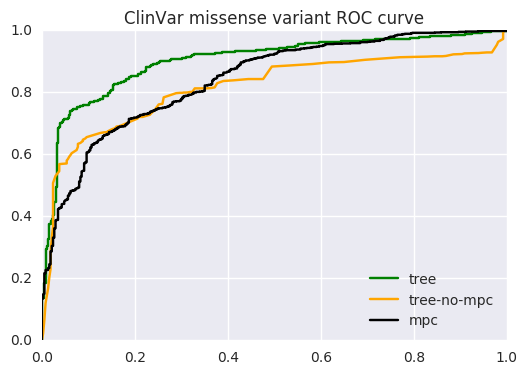

In [27]:
#X_clin, y_clin = clinvar_df[cols], clinvar_df['y']
#preds = tree_clf.predict_proba(X_clin)
#fpr_tree, tpr_tree, _ = metrics.roc_curve(y_clin, [x[1] for x in preds], pos_label=1)
#tree_auc = metrics.auc(fpr_tree, tpr_tree)
#mpc_auc = metrics.auc(fpr_mpc, tpr_mpc)
print('mpc auc', mpc_auc)
print('tree auc', tree_auc)
print('tree-no-mpc auc', tree_auc_nm)
plt.plot(fpr_tree, tpr_tree, label='tree', color='green')
plt.plot(fpr_tree_nm, tpr_tree_nm, label='tree-no-mpc', color='orange')
plt.plot(fpr_mpc, tpr_mpc, label='mpc', color='black')
plt.legend(loc=4)
plt.title('ClinVar missense variant ROC curve')
#plt.savefig('../docs/plots/missense_clinvar_roc_feature_union.png')